In [1]:
import numpy as np
import pandas as pd
import tweedie
import scipy.stats as st



def pred_list_to_prob_array(pred_list, cumulative=False, total_days=30):
    prob_array = np.zeros((pred_list.shape[0], total_days))
    pred_list = np.clip(pred_list, 1, total_days)
    for row, e in enumerate(pred_list):
        if cumulative:
            prob_array[row, int(e-1)] = 1.
        else:
            prob_array[row, int(e-1):] = 1.
        
    if cumulative:
        prob_array = prob_array+1e-4 
        prob_array = np.divide(prob_array, prob_array.sum(axis=1).reshape(-1,1))
        prob_array = prob_array.cumsum(axis=1)

    return prob_array

def pred_list_to_prob_array_mc(pred_list, total_days=30):
    prob_array = np.zeros((pred_list.shape[0], total_days))
    pred_list = np.clip(pred_list, 1, total_days)
    for row, e in enumerate(pred_list):
        prob_array[row, int(e):] = 1.
        
    return prob_array

def rps(y, p, probs=False, total_days=30):
    y_array = pred_list_to_prob_array(y, total_days=total_days)
    if probs:
        p_array = p.cumsum(axis=1)
    else:
        p_array = pred_list_to_prob_array(p, cumulative=True, total_days=total_days)
    return ((p_array - y_array)**2).sum(axis=1).mean()


def rps_mc(y, p, probs=False, total_days=30):
    y_array = pred_list_to_prob_array_mc(y, total_days=total_days)
    if probs:
        p_array = p.cumsum(axis=1)
    return ((p_array - y_array)**2).sum(axis=1).mean()

def rps_raw(y, p, probs=False):
    y_array = pred_list_to_prob_array(y)
    if probs:
        p_array = p.cumsum(axis=1)
    else:
        p_array = pred_list_to_prob_array(p, cumulative=True)
    return ((p_array - y_array)**2).sum(axis=1)


def pred_list_to_tweedie(pred_list, phi=1, p=1.5):
    # has a bug in the first day, it's the wrong probability, but it's worse without the bug
    distros = dict()
    for mu in range(1,31):
        distros[mu] = [tweedie.tweedie(p=p, mu=mu, phi=phi).cdf(days) for days in range(1,31,1)]
        distros[mu][1:] = np.diff(distros[mu])
        distros[mu] = np.round(distros[mu] / np.sum(distros[mu]), 4)
    
    prob_array = np.zeros((pred_list.shape[0], 30))

    for row, mu in enumerate(pred_list):
        prob_array[row, :] = distros[mu]#.cumsum()
        #prob_array[row, -1] = 1.

    return prob_array



def pred_list_to_distro(pred_list, wei=False, total_days=30, phi=2, power=1.5):
    distros = dict()
    for mu in range(1,total_days+1):
        if wei:
            distros[mu] = [st.norm.cdf(days, loc=mu, scale=1) for days in range(0,total_days+1,1)]
        else:
            distros[mu] = [tweedie.tweedie(p=power, mu=mu, phi=phi).cdf(days) for days in range(0,total_days+1,1)]
        #distros[mu] = [st.lognorm.cdf(days, s=0.5, loc=mu, scale=0.5) for days in range(0,31,1)]
        #distros[mu] = [st.expon.cdf(days, loc=mu, scale=0.01) for days in range(0,31,1)]
        #distros[mu] = [st.gengamma.cdf(days, loc=mu, scale=1, a=mu, c=1) for days in range(1,31,1)]
        if np.sum(distros[mu]) > 0:
            distros[mu] = np.diff(distros[mu])
            distros[mu] = np.round(distros[mu] / np.sum(distros[mu]), 4)
        else:
            distros[mu] = distros[mu][1:]
            distros[mu][-1] = 1
        
    
    prob_array = np.zeros((pred_list.shape[0], total_days))

    for row, mu in enumerate(pred_list):
        prob_array[row, :] = distros[mu]#.cumsum()
        #prob_array[row, -1] = 1.

    return prob_array

def pred_list_to_distro_smooth(pred_list, total_days=30, phi=2, power=1.5, smooth_factor=0.3):
    distros = dict()
    for mu in range(1,total_days+1):
        distros[mu] = [tweedie.tweedie(p=power, mu=mu, phi=phi).cdf(days) for days in range(0,total_days+1,1)]
        if np.sum(distros[mu]) > 0:
            distros[mu] = np.diff(distros[mu])
            distros[mu] = np.round(distros[mu] / np.sum(distros[mu]), 4)
        else:
            distros[mu] = distros[mu][1:]
            distros[mu][-1] = 1
        
    
    prob_array = np.zeros((pred_list.shape[0], total_days))

    for row, mu in enumerate(pred_list):
        if mu == 1:
            prob_array[row, :] = (1-smooth_factor)*distros[mu] + smooth_factor*distros[mu+1]
        elif mu == total_days:
            prob_array[row, :] = smooth_factor*distros[mu-1] + (1-smooth_factor)*distros[mu]
        else:
            prob_array[row, :] = (smooth_factor/2)*distros[mu-1] + (1-smooth_factor)*distros[mu] + (smooth_factor/2)*distros[mu+1]

    return prob_array

from sklearn.model_selection import GroupKFold, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import tweedie
from importlib import reload
from skopt import gp_minimize


In [2]:
train = pd.read_parquet('train_data.parquet')
train['date'] = pd.to_datetime(train['date'])
train['fold'] = train['date'].dt.month

In [3]:
test = pd.read_csv('test_data.csv', index_col = 0).squeeze() 

# what is the .squeeze?

In [4]:
train.dtypes

sku                                int64
date                      datetime64[ns]
sold_quantity                      int64
current_price                    float64
currency                          object
listing_type                      object
shipping_logistic_type            object
shipping_payment                  object
minutes_active                   float64
fold                               int64
dtype: object

In [5]:
train.head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,fold
0,464801,2021-02-01,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,2
1,464801,2021-02-02,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,2
2,464801,2021-02-03,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,2
3,464801,2021-02-04,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,2
4,464801,2021-02-05,1,156.78,REA,classic,fulfillment,free_shipping,1440.0,2


In [6]:
def gen_tr_ts():
    for fold in [2,3]:
        ts = train[train['fold'] != fold]['date'].max()
        ts = train[(train['fold'] != fold) & (train['date'] == ts)].index
        yield train.index[train['fold'] == fold], ts, fold
        
# Separates Between March and February

In [7]:
def gen_p(na=30., power=1.5):
    dts = list()
    for tr,ts, fold in gen_tr_ts():

        ## EVAL
        pp = train[train['fold'] != fold][['sku', 'date', 'sold_quantity']]
        pp['stock'] = pp['sku'].map(test)
        pp = pp.sort_values(["sku","date"])
        pp['cumulative_y'] = pp.groupby("sku")['sold_quantity'].cumsum()

        pp = pp.dropna(subset=['stock'])
        pp['stockout_y'] = pp['cumulative_y'] >= pp['stock']

        first_so_y = pp[pp['stockout_y']].groupby("sku").first()
        days_to_so_y = (first_so_y["date"] - pp["date"].min()) / np.timedelta64(1, 'D')
        days_to_so_y = days_to_so_y.reindex(pp['sku'].unique()).fillna(na).astype(int).clip(1)
        dts.append(days_to_so_y)

    m = pred_list_to_distro(dts[0], wei=False, total_days=max(na, 30), phi=2, power=power)
    f = pred_list_to_distro(dts[1].reindex(dts[0].index).fillna(dts[0]), wei=False, total_days=max(na, 30), phi=2, power=power)

    m = pd.DataFrame(m,index=dts[0].index)
    f = pd.DataFrame(f,index=dts[0].index)

    p = (m + f)/2

    p = p.div(p.sum(axis=1), axis=0)

    p = p.loc[test.index]
    
    p = p.round(4)

    return p

In [8]:
r = {i:gen_p(30, power=i/10) for i in range(11,20,1)}

<AxesSubplot:>

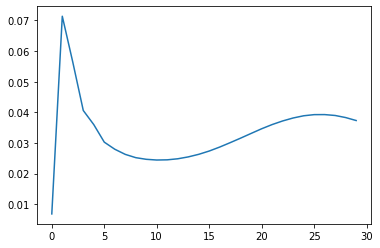

In [9]:
r[11].mean(axis = 0).plot()

<AxesSubplot:>

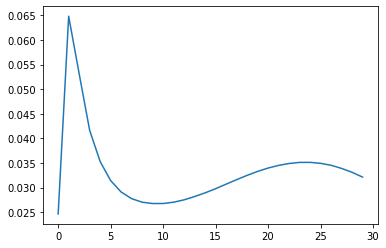

In [11]:
r[12].mean(axis = 0).plot()

<AxesSubplot:>

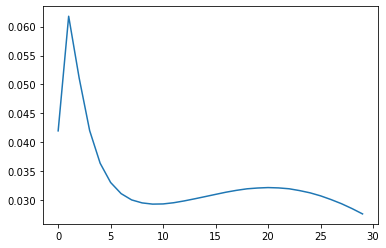

In [15]:
r[13].mean(axis = 0).plot()

In [ ]:
r[13].round(4).to_csv('JoaoTonhatiSubmition.csv.gz', header = 'False', index = 'False', compression = 'gzip')